In [136]:
#Libraries
import streamlit as st
import pandas as pd
import pandas_ta as ta
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from binance.client import Client
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

Part 1

In [137]:
#Read in data
#https://github.com/binance/binance-public-data/

client = Client()

# Set the start date and current date
start_date = "1 Jan, 2020"
end_date = datetime.now().strftime("%d %b, %Y")

# Fetch the klines/candlestick data
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, start_date, end_date)

# Create a DataFrame
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Convert relevant columns to float
float_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
df[float_columns] = df[float_columns].astype(float)

copy = df.copy()

In [138]:
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
timestamp,,,,,,,,,,,
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165,1577923199999,1.212145e+08,194010.0,8946.955535,6.459779e+07,0
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932,1578009599999,2.259823e+08,302667.0,15141.611340,1.070608e+08,0
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451,1578095999999,4.950986e+08,519854.0,35595.496273,2.577131e+08,0
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977,1578182399999,2.198742e+08,279370.0,16369.382248,1.200351e+08,0
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604,1578268799999,2.848487e+08,329209.0,19455.369564,1.446001e+08,0


In [139]:
df['returns'] = np.log(df.close.pct_change() + 1)
df['direction'] = [1 if i>0 else 0 for i in df.returns]

In [140]:
def lagit(df, lags):
    names = []
    for i in range(1, lags+1):
        df['Lag_'+str(i)] = df['returns'].shift(i)
        df['Lag_'+str(i)+'_dir'] = [1 if j>0 else 0 for j in df['Lag_'+str(i)]]
        names.append('Lag_'+str(i)+'_dir')
    return names

In [141]:
dirnames = lagit(df, 5)

In [142]:
df.dropna(inplace=True)

In [143]:
model = LogisticRegression()

In [144]:
df[dirnames]

,Lag_1_dir,Lag_2_dir,Lag_3_dir,Lag_4_dir,Lag_5_dir
timestamp,,,,,
2020-01-07,1,1,1,1,0
2020-01-08,1,1,1,1,1
2020-01-09,0,1,1,1,1
2020-01-10,0,0,1,1,1
2020-01-11,1,0,0,1,1
...,...,...,...,...,...
2024-07-12,0,0,1,1,0
2024-07-13,1,0,0,1,1
2024-07-14,1,1,0,0,1


In [145]:
model.fit(df[dirnames], df['direction'])

LogisticRegression()

In [146]:
df['prediction_Logit'] = model.predict(df[dirnames])

In [147]:
df['strat_Logit'] = df['prediction_Logit'] * df['returns']

In [148]:
np.exp(df[['returns', 'strat_Logit']].sum())

returns         8.399803
strat_Logit    12.007959
dtype: float64

<Axes: xlabel='timestamp'>

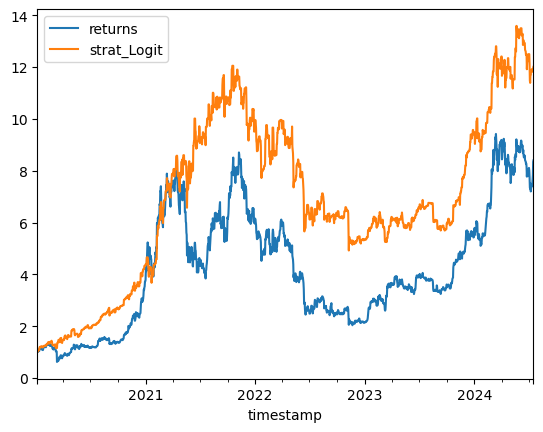

In [149]:
np.exp(df[['returns', 'strat_Logit']].cumsum()).plot()

In [150]:
train, test = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)
train = train.copy()
test = test.copy()

model = LogisticRegression()

model.fit(train[dirnames], train['direction'])

LogisticRegression()

In [151]:
test['prediction_Logit'] = model.predict(test[dirnames])

In [152]:
test['strat_Logit'] = test['prediction_Logit']*test['returns']

In [153]:
np.exp(test[['returns', 'strat_Logit']].sum())

returns        2.488190
strat_Logit    1.409771
dtype: float64

<Axes: xlabel='timestamp'>

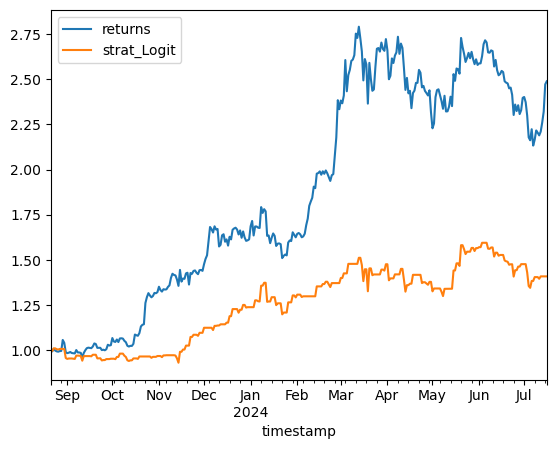

In [154]:
np.exp(test[['returns', 'strat_Logit']].cumsum()).plot()

In [155]:
metrics.confusion_matrix(test['direction'], test['prediction_Logit'])

array([[88, 68],
       [87, 88]])

In [156]:
print(metrics.classification_report(test['direction'], test['prediction_Logit']))

              precision    recall  f1-score   support

           0       0.50      0.56      0.53       156
           1       0.56      0.50      0.53       175

    accuracy                           0.53       331
   macro avg       0.53      0.53      0.53       331
weighted avg       0.54      0.53      0.53       331



Part 2 - Using lags direction (binary)

In [157]:
df = copy.copy()
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
timestamp,,,,,,,,,,,
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165,1577923199999,1.212145e+08,194010.0,8946.955535,6.459779e+07,0
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932,1578009599999,2.259823e+08,302667.0,15141.611340,1.070608e+08,0
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451,1578095999999,4.950986e+08,519854.0,35595.496273,2.577131e+08,0
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977,1578182399999,2.198742e+08,279370.0,16369.382248,1.200351e+08,0
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604,1578268799999,2.848487e+08,329209.0,19455.369564,1.446001e+08,0


In [158]:
df['returns'] = np.log(df.close.pct_change() + 1)
df['direction'] = [1 if i>0 else 0 for i in df.returns]

def lagit(df, lags):
    names = []
    for i in range(1, lags+1):
        df['Lag_'+str(i)] = df['returns'].shift(i)
        df['Lag_'+str(i)+'_dir'] = [1 if j>0 else 0 for j in df['Lag_'+str(i)]]
        names.append('Lag_'+str(i)+'_dir')
    return names

dirnames = lagit(df, 5)
df.dropna(inplace=True)

df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,Lag_1,Lag_1_dir,Lag_2,Lag_2_dir,Lag_3,Lag_3_dir,Lag_4,Lag_4_dir,Lag_5,Lag_5_dir
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-07,7758.90,8207.68,7723.71,8145.28,91171.684661,1578441599999,7.242028e+08,685315.0,46192.111549,3.668670e+08,...,0.052834,1,0.000631,1,0.001245,1,0.053015,1,-0.033200,0
2020-01-08,8145.92,8455.00,7870.00,8055.98,112622.642640,1578527999999,9.264102e+08,830375.0,55071.109514,4.532843e+08,...,0.048714,1,0.052834,1,0.000631,1,0.001245,1,0.053015,1
2020-01-09,8054.72,8055.96,7750.00,7817.76,64239.519830,1578614399999,5.072583e+08,478800.0,31645.759221,2.498997e+08,...,-0.011024,0,0.048714,1,0.052834,1,0.000631,1,0.001245,1
2020-01-10,7817.74,8199.00,7672.00,8197.02,82406.777448,1578700799999,6.527742e+08,606101.0,42361.755307,3.358454e+08,...,-0.030017,0,-0.011024,0,0.048714,1,0.052834,1,0.000631,1
2020-01-11,8198.86,8286.34,8003.16,8020.01,54810.032667,1578787199999,4.450343e+08,469131.0,27916.124974,2.267160e+08,...,0.047373,1,-0.030017,0,-0.011024,0,0.048714,1,0.052834,1


In [159]:
X = df[dirnames]
y = df['direction']

log_reg = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))


[[88 68]
 [87 88]]


In [160]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.56      0.53       156
           1       0.56      0.50      0.53       175

    accuracy                           0.53       331
   macro avg       0.53      0.53      0.53       331
weighted avg       0.54      0.53      0.53       331



Part 3 - Using lags (integer)

In [161]:
df = copy.copy()
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
timestamp,,,,,,,,,,,
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165,1577923199999,1.212145e+08,194010.0,8946.955535,6.459779e+07,0
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932,1578009599999,2.259823e+08,302667.0,15141.611340,1.070608e+08,0
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451,1578095999999,4.950986e+08,519854.0,35595.496273,2.577131e+08,0
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977,1578182399999,2.198742e+08,279370.0,16369.382248,1.200351e+08,0
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604,1578268799999,2.848487e+08,329209.0,19455.369564,1.446001e+08,0


In [162]:
df['returns'] = np.log(df.close.pct_change() + 1)
df['direction'] = [1 if i>0 else 0 for i in df.returns]

def lagit(df, lags):
    names = []
    for i in range(1, lags+1):
        df['Lag_'+str(i)] = df['returns'].shift(i)
        df['Lag_'+str(i)+'_dir'] = [1 if j>0 else 0 for j in df['Lag_'+str(i)]]
        names.append('Lag_'+str(i)+'_dir')
    return names

dirnames = lagit(df, 5)
df.dropna(inplace=True)

df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,Lag_1,Lag_1_dir,Lag_2,Lag_2_dir,Lag_3,Lag_3_dir,Lag_4,Lag_4_dir,Lag_5,Lag_5_dir
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-07,7758.90,8207.68,7723.71,8145.28,91171.684661,1578441599999,7.242028e+08,685315.0,46192.111549,3.668670e+08,...,0.052834,1,0.000631,1,0.001245,1,0.053015,1,-0.033200,0
2020-01-08,8145.92,8455.00,7870.00,8055.98,112622.642640,1578527999999,9.264102e+08,830375.0,55071.109514,4.532843e+08,...,0.048714,1,0.052834,1,0.000631,1,0.001245,1,0.053015,1
2020-01-09,8054.72,8055.96,7750.00,7817.76,64239.519830,1578614399999,5.072583e+08,478800.0,31645.759221,2.498997e+08,...,-0.011024,0,0.048714,1,0.052834,1,0.000631,1,0.001245,1
2020-01-10,7817.74,8199.00,7672.00,8197.02,82406.777448,1578700799999,6.527742e+08,606101.0,42361.755307,3.358454e+08,...,-0.030017,0,-0.011024,0,0.048714,1,0.052834,1,0.000631,1
2020-01-11,8198.86,8286.34,8003.16,8020.01,54810.032667,1578787199999,4.450343e+08,469131.0,27916.124974,2.267160e+08,...,0.047373,1,-0.030017,0,-0.011024,0,0.048714,1,0.052834,1


In [165]:
X = df[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']]
y = df['direction']

log_reg = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))


[[ 34 122]
 [ 32 143]]
              precision    recall  f1-score   support

           0       0.52      0.22      0.31       156
           1       0.54      0.82      0.65       175

    accuracy                           0.53       331
   macro avg       0.53      0.52      0.48       331
weighted avg       0.53      0.53      0.49       331



In [166]:
X = df[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']+dirnames]
y = df['direction']

log_reg = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))


[[86 70]
 [83 92]]
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       156
           1       0.57      0.53      0.55       175

    accuracy                           0.54       331
   macro avg       0.54      0.54      0.54       331
weighted avg       0.54      0.54      0.54       331

